In [1]:
### HJM Estimation

In [2]:
# Other inputs
from mpl_toolkits.mplot3d import Axes3D
import copy as copylib
#from progressbar import *
%pylab
%matplotlib inline
import pandas
pylab.rcParams['figure.figsize'] = (16, 4.5)
numpy.random.seed(0)

# My inputs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pickle


Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [3]:
# Load historical data

In [3]:
# Need to change this to be my dataframe
#dataframe =  pandas.DataFrame.from_csv('hjm_data.csv')
#dataframe = dataframe / 100 # Convert interest rates to %
dataframe= pickle.load(open('forward_rates', 'rb'))

pandas.options.display.max_rows = 10
display(dataframe)


FileNotFoundError: [Errno 2] No such file or directory: 'forward_rates'

In [10]:
dataframe= pickle.load(open('../data/forward_rates', 'rb'))


In [12]:

pandas.options.display.max_rows = 10
display(dataframe)


,six_m,one_y,two_y,three_y,five_y,seven_y,ten_y
Date,,,,,,,
2006-01-03,0.0440,0.0438,0.043462,0.042645,0.043437,0.044239,0.045619
2006-01-04,0.0437,0.0435,0.043156,0.042645,0.043232,0.044428,0.045493
2006-01-05,0.0437,0.0436,0.043258,0.042747,0.043335,0.044172,0.045493
2006-01-06,0.0439,0.0438,0.043871,0.042850,0.043641,0.044085,0.045688
2006-01-09,0.0440,0.0439,0.043769,0.042850,0.043641,0.044443,0.045415
...,...,...,...,...,...,...,...
2019-03-22,0.0248,0.0245,0.021819,0.021111,0.022500,0.026237,0.027157
2019-03-25,0.0249,0.0241,0.021212,0.020606,0.022525,0.026299,0.027303
2019-03-26,0.0249,0.0244,0.020506,0.020707,0.021894,0.026020,0.027371


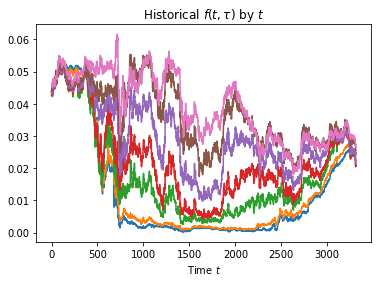

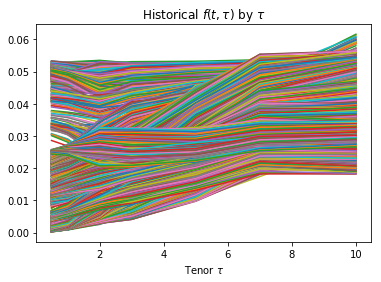

In [13]:
hist_timeline = list(dataframe.index)
tenors = [0.5, 1, 2, 3, 5, 7, 10]
hist_rates = matrix(dataframe)
plot(hist_rates), xlabel(r'Time $t$'), title(r'Historical $f(t,\tau)$ by $t$'), show()
plot(tenors, hist_rates.transpose()), xlabel(r'Tenor $\tau$'), title(r'Historical $f(t,\tau)$ by $\tau$');


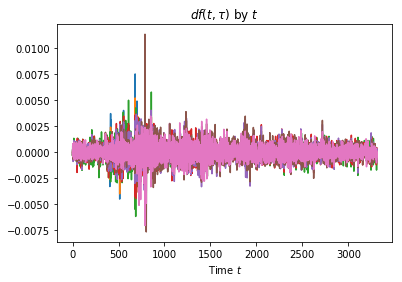

In [14]:
# Differentiate Historical Rates to get stationary
diff_rates = diff(hist_rates, axis=0)
assert(hist_rates.shape[1]==diff_rates.shape[1])
plot(diff_rates), xlabel(r'Time $t$'), title(r'$df(t,\tau)$ by $t$');

In [81]:
diff_rates.shape

(3312, 7)

In [54]:
# looking at the differenced forward series
delta_fwds = pd.DataFrame(diff_rates)
delta_fwds.describe()

,0,1,2,3,4,5,6
count,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000
mean,-0.000006,-0.000006,-0.000007,-0.000007,-0.000006,-0.000006,-0.000006
std,0.000385,0.000351,0.000712,0.000757,0.000795,0.000818,0.000700
min,-0.004900,-0.004000,-0.006169,-0.004756,-0.007153,-0.007652,-0.007034
25%,-0.000100,-0.000100,-0.000401,-0.000408,-0.000457,-0.000458,-0.000406
50%,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000021,0.000000
75%,0.000100,0.000100,0.000401,0.000405,0.000431,0.000441,0.000377
max,0.007500,0.005200,0.005763,0.003650,0.004026,0.011311,0.003459


## Principal Component Analysis

In [82]:
# calculate the covariance matrix
sigma = cov(diff_rates.transpose())
print("sigma shape :", str(sigma.shape))

sigma shape : (7, 7)


In [21]:
# since our data is daily we need to annualize the covariance matrix
sigma *= 252

### Calculate the eignevalues and eigenvectors

In [83]:
eigval, eigvec = np.linalg.eig(sigma)
eigvec = matrix(eigvec)
assert type(eigval)==ndarray
assert type(eigvec)==matrix
print(eigval)

[2.06189459e-06 3.89622617e-07 1.88453779e-08 1.11452904e-07
 1.62171651e-07 2.08477985e-07 1.90650582e-07]


In [26]:
print(eigvec)

[[-0.08304166 -0.25569049  0.61115972  0.09434899  0.51839551  0.46951703
   0.23691427]
 [-0.11942444 -0.27566908 -0.78709315  0.07542939  0.37976301  0.3238288
   0.18829259]
 [-0.37531276 -0.53971823  0.0701012   0.38656388  0.03789802 -0.63088267
   0.11853079]
 [-0.44394394 -0.33777426  0.03595749 -0.02209052 -0.66468226  0.48337183
  -0.1076595 ]
 [-0.51395316  0.02667438  0.02177133 -0.8070833   0.21433515 -0.19165646
   0.02472702]
 [-0.49593664  0.39558417 -0.01158162  0.3639569   0.27487377  0.07853653
  -0.61906194]
 [-0.36165592  0.54409866 -0.01236602  0.22724649 -0.14937282  0.01127887
   0.70634857]]


Principal eigenvalues
[5.19597438e-04 9.81848996e-05 5.25364521e-05]

Principal eigenvectors
[[-0.08304166 -0.25569049  0.46951703]
 [-0.11942444 -0.27566908  0.3238288 ]
 [-0.37531276 -0.53971823 -0.63088267]
 [-0.44394394 -0.33777426  0.48337183]
 [-0.51395316  0.02667438 -0.19165646]
 [-0.49593664  0.39558417  0.07853653]
 [-0.36165592  0.54409866  0.01127887]]


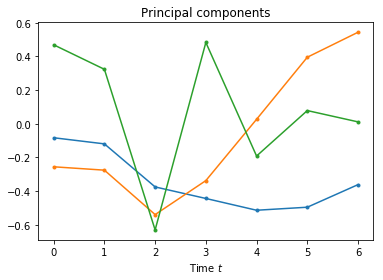

In [35]:
# determine principal components
factors=3
index_eigvec = list(reversed(eigval.argsort()))[0:factors]   # highest principal component first in the array
princ_eigval = array([eigval[i] for i in index_eigvec])
princ_comp = hstack([eigvec[:,i] for i in index_eigvec])
print("Principal eigenvalues")
print(princ_eigval)
print()
print("Principal eigenvectors")
print(princ_comp)
plot(princ_comp, marker='.'), title('Principal components'), xlabel(r'Time $t$');

## Calculate discretized volatlity functin from principal components

vols shape: (7, 3)


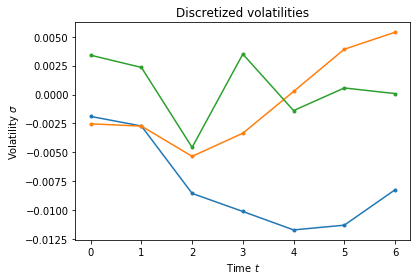

In [36]:
sqrt_eigval = matrix(princ_eigval ** .5)
tmp_m = vstack([sqrt_eigval for i in range(princ_comp.shape[0])])  # resize matrix (1,factors) to (n, factors)
vols = multiply(tmp_m, princ_comp) # multiply matrice element-wise
print('vols shape: ' + str(vols.shape))
plot(vols, marker='.'), xlabel(r'Time $t$'), ylabel(r'Volatility $\sigma$'), title('Discretized volatilities');


# Volatility Fitting


In [37]:
def get_matrix_column(mat, i):
    return array(mat[:,i].flatten())[0]

class PolynomialInterpolator:
    def __init__(self, params):
        assert type(params) == ndarray
        self.params = params
    def calc(self, x):
        n = len(self.params)
        C = self.params
        X = array([x**i for i in reversed(range(n))])
        return sum(multiply(X, C))

In [38]:
fitted_vols = []

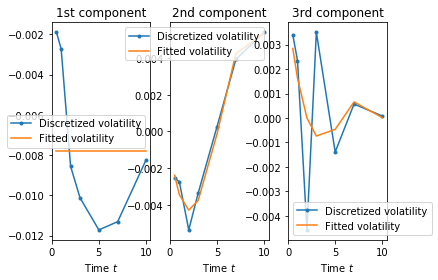

In [39]:
def fit_volatility(i, degree, title):
    vol = get_matrix_column(vols, i)
    fitted_vol = PolynomialInterpolator(polyfit(tenors, vol, degree))    
    plot(tenors, vol, marker='.', label='Discretized volatility')
    plot(tenors, [fitted_vol.calc(x) for x in tenors], label='Fitted volatility')
    plt.title(title), xlabel(r'Time $t$'), legend();
    fitted_vols.append(fitted_vol)
    
subplot(1, 3, 1), fit_volatility(0, 0, '1st component');
subplot(1, 3, 2), fit_volatility(1, 3, '2nd component');
subplot(1, 3, 3), fit_volatility(2, 3, '3rd component');

## Monte Carlo Simulation

In [40]:
def integrate(f, x0, x1, dx):
    n = (x1-x0)/dx+1
    out = 0
    for i, x in enumerate(linspace(x0, x1, n)):
        if i==0 or i==n-1:
            out += 0.5 * f(x)
        else:
            out += f(x)  # not adjusted by *0.5 because of repeating terms x1...xn-1 - see trapezoidal rule
    out *= dx
    return out


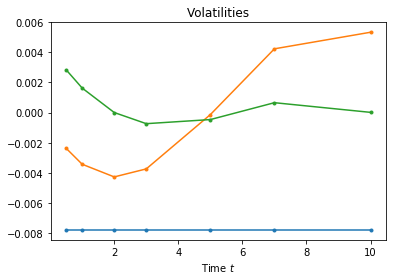

In [56]:
#mc_tenors = linspace(0,25,51)
mc_tenors = np.array([0.5, 1, 2, 3, 5, 7, 10])
# Discretize fitted volfuncs for the purpose of monte carlo simulation
mc_vols = matrix([[fitted_vol.calc(tenor) for tenor in mc_tenors] for fitted_vol in fitted_vols]).transpose()
plot(mc_tenors, mc_vols, marker='.'), xlabel(r'Time $t$'), title('Volatilities');


In [42]:
# Drift Calculation

In [57]:
def m(tau, fitted_vols):
    #This funciton carries out integration for all principal factors. 
    #It uses the fact that volatility is function of time in HJM model
    out = 0.
    for fitted_vol in fitted_vols:
        assert isinstance(fitted_vol, PolynomialInterpolator)
        out += integrate(fitted_vol.calc, 0, tau, 0.01) * fitted_vol.calc(tau)
    return out

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.


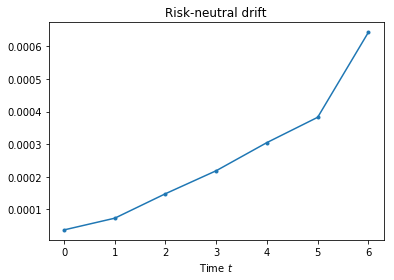

In [58]:
mc_drift = array([m(tau, fitted_vols) for tau in mc_tenors])
plot(mc_drift, marker='.'), xlabel(r'Time $t$'), title('Risk-neutral drift');

# Perform Monte Carlo Simulations (one path)

In [86]:
whos

Variable                 Type         Data/Info
-----------------------------------------------
Axes3D                   type         <class 'mpl_toolkits.mplot3d.axes3d.Axes3D'>
PCA                      ABCMeta      <class 'sklearn.decomposition.pca.PCA'>
PolynomialInterpolator   type         <class '__main__.PolynomialInterpolator'>
copylib                  module       <module 'copy' from '/ana<...>3/lib/python3.6/copy.py'>
curve_spot               ndarray      7: 7 elems, type `float64`, 56 bytes
dataframe                DataFrame                 six_m   one_<...>\n[3313 rows x 7 columns]
delta_fwds               DataFrame               0       1     <...>\n[3312 rows x 7 columns]
diff_rates               matrix       [[-3.00000000e-04 -3.0000<...>775e-04 -2.70692687e-04]]
eigval                   ndarray      7: 7 elems, type `float64`, 56 bytes
eigvec                   matrix       [[ 0.08304166  0.25569049<...>01127887\n   0.70634857]]
f                        ndarray      7: 7 

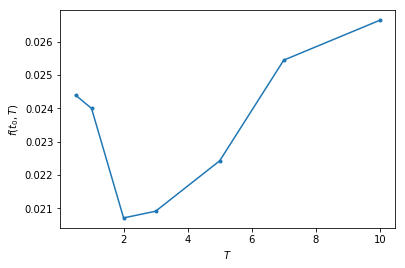

In [84]:
curve_spot = array(hist_rates[-1,:].flatten())[0]
plot(mc_tenors, curve_spot.transpose(), marker='.'), ylabel('$f(t_0,T)$'), xlabel("$T$");

In [74]:
def simulation(f, tenors, drift, vols, timeline):
    assert type(tenors)==ndarray
    assert type(f)==ndarray
    assert type(drift)==ndarray
    assert type(timeline)==ndarray
    assert len(f)==len(tenors)
    vols = array(vols.transpose())  # 3 rows, T columns
    len_tenors = len(tenors)
    len_vols = len(vols)
    yield timeline[0], copylib.copy(f)
    for it in range(1, len(timeline)):
        t = timeline[it]
        dt = t - timeline[it-1]
        sqrt_dt = sqrt(dt)
        fprev = f
        f = copylib.copy(f)
        random_numbers = [normal() for i in range(len_vols)]
        for iT in range(len_tenors):
            val = fprev[iT] + drift[iT] * dt
            #
            sum = 0
            for iVol, vol in enumerate(vols):
                #sum += vol[iT] * random_numbers[iVol]
                sum += vol[iT] * random_numbers[iVol] * 0
            val += sum * sqrt_dt
            #
            iT1 = iT+1 if iT<len_tenors-1 else iT-1   # if we can't take right difference, take left difference
            dfdT = (fprev[iT1] - fprev[iT]) / (iT1 - iT)
            val += dfdT * dt
            #
            f[iT] = val
        yield t,f

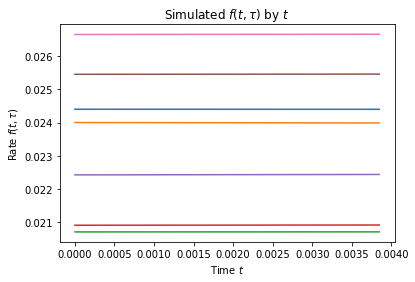

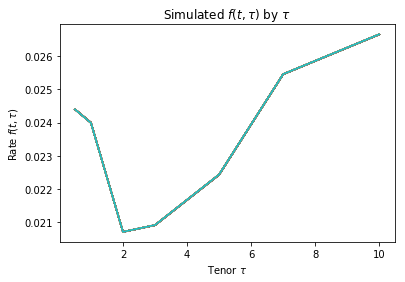

(Text(0.5, 1.0, 'Simulated $f(t,\\tau)$ by $\\tau$'), None)

In [75]:
proj_rates = []
proj_timeline = linspace(0,1/260)
#progressbar = ProgressBar("One simulation path", len(proj_timeline))
for i, (t, f) in enumerate(simulation(curve_spot, mc_tenors, mc_drift, mc_vols, proj_timeline)):
    #progressbar.update(i)
    proj_rates.append(f)
proj_rates = matrix(proj_rates)
plot(proj_timeline.transpose(), proj_rates), xlabel(r'Time $t$'), ylabel(r'Rate $f(t,\tau)$');
title(r'Simulated $f(t,\tau)$ by $t$'), show()
plot(mc_tenors, proj_rates.transpose()), xlabel(r'Tenor $\tau$'), ylabel(r'Rate $f(t,\tau)$');
title(r'Simulated $f(t,\tau)$ by $\tau$'), show()

In [6]:
pwd

'/Users/davidsmith/Documents/Galvanize/Capstone/src'

# BELOW IS MY CODE FOR DOING PCA

In [8]:

X_fwds = pickle.load(open('../data/forward_rates', 'rb'))
#X_fwds = df_add_first_diff(X_fwds)

#df_FX = pickle.load( open( "data/FX_data", "rb" ) )
# Loading up the federal reserve speech data
fed_metrics = pickle.load( open( "../data/mvp_cosine_sim", "rb" ) )
cos_last = fed_metrics['cos_last']
cos_avg_n = fed_metrics['cos_avg_n']
ed_last = fed_metrics['ed_last']
ed_avg_n = fed_metrics['ed_avg_n']
fed_dates = fed_metrics['dates']

#grouping by date (some dates had multiple speeches)
avgstats = pd.DataFrame({'date':fed_dates,
                        'ed_last': ed_last,
                        'ed_avg_n': ed_avg_n,
                        'cos_last': cos_last,
                        'cos_avg_n': cos_avg_n}).groupby('date').mean()
avgstats.index = pd.to_datetime(avgstats.index)

X_fwds = X_fwds.merge(avgstats, how='left', left_index = True, right_index = True)
X_fwds.fillna(value=0, inplace=True)

# the first row of X_fwds contains zeros for the differenced rates, clear them here
X_fwds = X_fwds.drop(X_fwds.index[0])

# Creating training, cross-validation and test datasets
total_obs = len(X_fwds)
train_int = int(round(total_obs*.7, 0))
cv_int = int(round(total_obs*.85, 0))

fwd_train = X_fwds[0:train_int]
fwd_cv = X_fwds[train_int:cv_int]
fwd_test = X_fwds[cv_int:]

# saving the cross validation data set for reporting and charts later
pickle_out = open('../data/fwd_cv_data', 'wb')
pickle.dump(fwd_cv, pickle_out)
pickle_out.close()

In [17]:
from sklearn.decomposition import PCA
test = PCA(n_components = 7, random_state=0)

In [15]:
diff_rates = fwd_cv[['d_six_m', 'd_one_y', 'd_two_y', 'd_three_y', 'd_five_y', 'd_seven_y', 'd_ten_y']]
diff_rates.describe()

,d_six_m,d_one_y,d_two_y,d_three_y,d_five_y,d_seven_y,d_ten_y
count,497.000000,497.000000,497.000000,497.000000,497.000000,497.000000,497.000000
mean,0.000016,0.000016,0.000014,0.000009,0.000011,0.000009,0.000008
std,0.000196,0.000365,0.000551,0.000635,0.000621,0.000691,0.000575
min,-0.000800,-0.001506,-0.002012,-0.002012,-0.002007,-0.002510,-0.001964
25%,-0.000100,-0.000201,-0.000303,-0.000405,-0.000430,-0.000416,-0.000372
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000100,0.000201,0.000402,0.000503,0.000407,0.000469,0.000338
max,0.001000,0.001708,0.001813,0.001816,0.002655,0.003046,0.002071


In [18]:
test.fit(diff_rates)

PCA(copy=True, iterated_power='auto', n_components=7, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)

In [19]:
print("Explained variance of first pc: {0:2.2f}".format(test.explained_variance_ratio_[0]))
print("Explained variance of second pc: {0:2.2f}".format(test.explained_variance_ratio_[1]))
print("Explained variance of third pc: {0:2.2f}".format(test.explained_variance_ratio_[2]))
print("Explained variance of forth pc: {0:2.2f}".format(test.explained_variance_ratio_[3]))
print("Explained variance of fith pc: {0:2.2f}".format(test.explained_variance_ratio_[4]))
#test.explained_variance_ratio_

Explained variance of first pc: 0.69
Explained variance of second pc: 0.09
Explained variance of third pc: 0.07
Explained variance of forth pc: 0.06
Explained variance of fith pc: 0.05


In [20]:
shocks = test.fit_transform(diff_rates)
shocks.shape

(497, 7)

Text(0.5, 1.0, 'Third principal component coefficients')

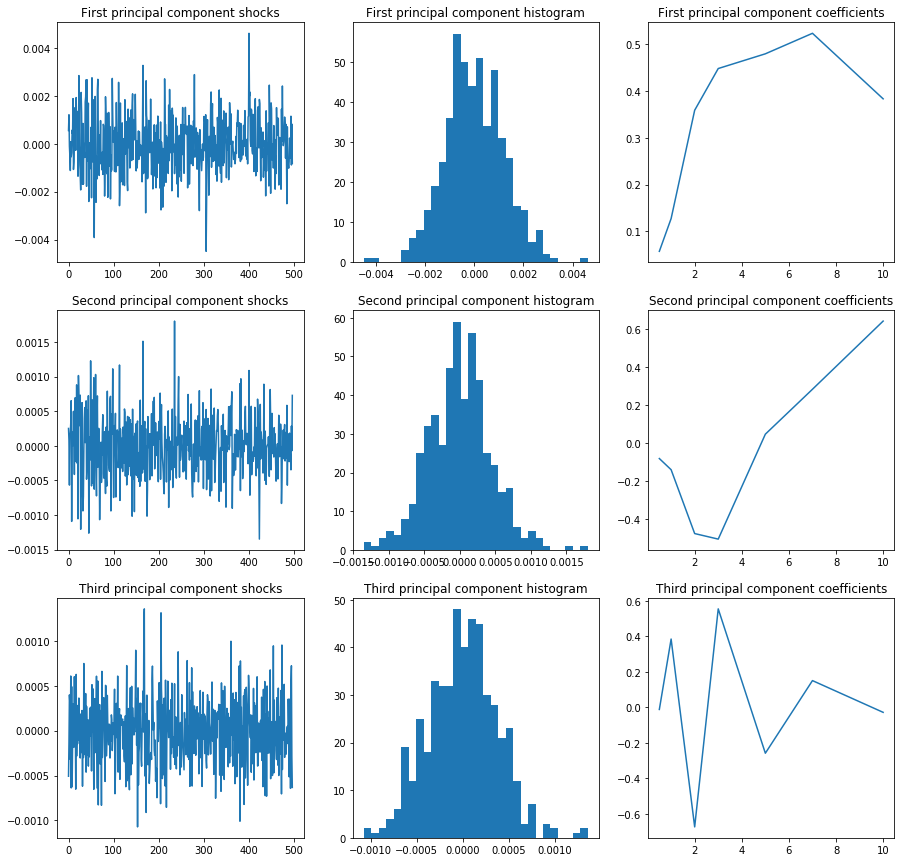

In [40]:
components = test.components_
x_comp = [0.5, 1, 2, 3, 5, 7, 10]
fig, axs = plt.subplots(3,3, figsize=(15,15))

axs[0,0].plot(shocks[:,0])
axs[0,0].set_title('First principal component shocks')
axs[0,1].hist(shocks[:,0], bins = 30)
axs[0,1].set_title('First principal component histogram')
axs[0,2].plot(x_comp, components[0,:])
axs[0,2].set_title('First principal component coefficients')

axs[1,0].plot(shocks[:,1])
axs[1,0].set_title('Second principal component shocks')
axs[1,1].hist(shocks[:,1], bins = 30)
axs[1,1].set_title('Second principal component histogram')
axs[1,2].plot(x_comp, components[1,:])
axs[1,2].set_title('Second principal component coefficients')


axs[2,0].plot(shocks[:,2])
axs[2,0].set_title('Third principal component shocks')
axs[2,1].hist(shocks[:,2], bins = 30)
axs[2,1].set_title('Third principal component histogram')
axs[2,2].plot(x_comp, components[2,:])
axs[2,2].set_title('Third principal component coefficients')



In [36]:
test.components_


array([[ 0.05745424,  0.12742875,  0.35894349,  0.44808795,  0.47954242,
         0.52337856,  0.3833427 ],
       [-0.07994328, -0.1386906 , -0.47431076, -0.50346492,  0.04810012,
         0.2841849 ,  0.64253536],
       [-0.01156965,  0.38508043, -0.673282  ,  0.55505034, -0.25811628,
         0.1509621 , -0.02785859],
       [-0.02222896, -0.63481441, -0.02514436,  0.0868795 , -0.29400108,
         0.62013214, -0.34254304],
       [-0.07908579,  0.59048161,  0.03985843, -0.46937217,  0.09473443,
         0.47260467, -0.43686175],
       [-0.12470935,  0.24905935,  0.43654324, -0.01366468, -0.76838956,
         0.10511605,  0.36081629],
       [ 0.98380542,  0.05051203, -0.00944912, -0.09805292, -0.12356238,
         0.05963079,  0.03237697]])

In [41]:
whos

Variable      Type              Data/Info
-----------------------------------------
Axes3D        type              <class 'mpl_toolkits.mplot3d.axes3d.Axes3D'>
PCA           ABCMeta           <class 'sklearn.decomposition.pca.PCA'>
X_fwds        DataFrame                      six_m     on<...>n[3312 rows x 18 columns]
avgstats      DataFrame                      ed_last  ed_<...>n\n[521 rows x 4 columns]
axs           ndarray           3x3: 9 elems, type `object`, 72 bytes
components    ndarray           7x7: 49 elems, type `float64`, 392 bytes
copylib       module            <module 'copy' from '/ana<...>3/lib/python3.6/copy.py'>
cos_avg_n     ndarray           594: 594 elems, type `float64`, 4752 bytes
cos_last      ndarray           594: 594 elems, type `float64`, 4752 bytes
cv_int        int               2815
diff_rates    DataFrame                     d_six_m      <...>n\n[497 rows x 7 columns]
ed_avg_n      ndarray           594: 594 elems, type `float64`, 4752 bytes
ed_last   

In [46]:
this_prediction = np.zeros(shape=(1,7))
this_prediction

array([[0., 0., 0., 0., 0., 0., 0.]])